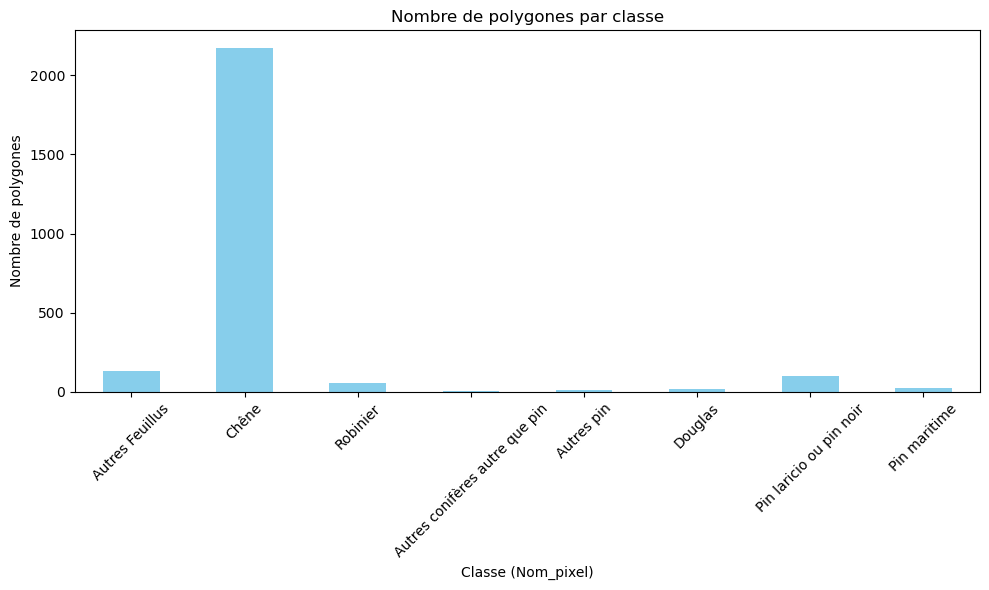

In [55]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
from osgeo import gdal, ogr

# Charger la couche vectorielle
shapefile_path = "../results/data/sample/Sample_BD_foret_T31TCJ.shp"
data = gpd.read_file(shapefile_path)

data = data.to_crs(epsg=2154)

data = data[~data['Code_pixel'].isna()]
data = data[data['Code_pixel'] != 0]

# Étape 1 : Calculer le nombre de polygones par classe
polygons_by_class = data['Code_pixel'].value_counts().sort_index()

# Créer une correspondance entre 'Code_pixel' et 'Nom_pixel'
class_names = dict(zip(data['Code_pixel'], data['Nom_pixel']))

# Remplacer les 'Code_pixel' par les noms des classes pour les affichages sur l'axe des x
polygons_by_class.index = polygons_by_class.index.map(class_names)

# Diagramme en bâtons : Nombre de polygones par classe
plt.figure(figsize=(10, 6))
polygons_by_class.plot(kind='bar', color='skyblue')
plt.title("Nombre de polygones par classe")
plt.xlabel("Classe (Nom_pixel)")
plt.ylabel("Nombre de polygones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/figure/diag_baton_nb_poly_by_class.png")
plt.show()  # Afficher le graphique
plt.close()

In [56]:
# Définir les coordonnées de la bounding box
minx, miny, maxx, maxy = data.total_bounds

# Définir la taille de la résolution du raster
pixel_size = 10  # taille de pixel en unités CRS
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Créer un fichier raster vide en utilisant GDAL
driver = gdal.GetDriverByName('GTiff')
output_raster_path = "../results/figure/rasterized_output.tif"
out_raster = driver.Create(output_raster_path, width, height, 1, gdal.GDT_UInt16)

# Définir la transformation géoréférencée
geotransform = (minx, pixel_size, 0, maxy, 0, -pixel_size)
out_raster.SetGeoTransform(geotransform)

# Définir la projection (assurez-vous que la projection est correcte pour ArcGIS)
out_raster.SetProjection('EPSG:2154')  # ou data.crs.to_wkt() si nécessaire

# Ouvrir le shapefile avec ogr pour obtenir la couche
shapefile = ogr.Open(shapefile_path)
layer = shapefile.GetLayer()

# Rasteriser la couche avec la colonne 'Code_pixel' comme valeurs de pixel
gdal.RasterizeLayer(out_raster, [1], layer, options=["ATTRIBUTE=Code_pixel"])

# Fermer le fichier raster et la couche
out_raster = None
shapefile = None

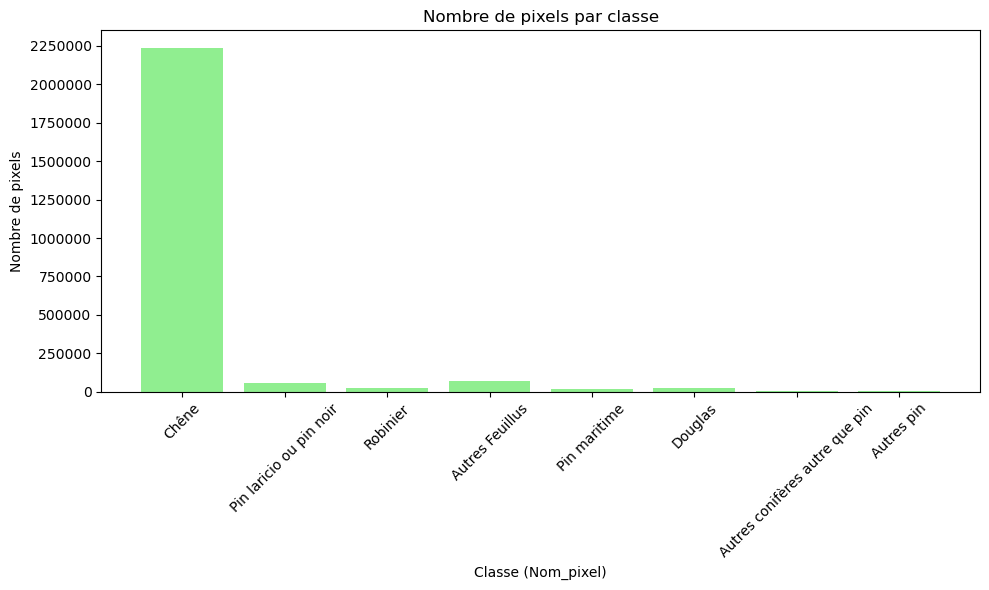

In [59]:
# Lire le raster créé pour compter les pixels par classe
raster_ds = gdal.Open(output_raster_path)
band = raster_ds.GetRasterBand(1)
raster_data = band.ReadAsArray()

# Compter le nombre de pixels pour chaque classe
pixel_counts = {}
for row in raster_data:
    for pixel in row:
        if pixel != -9999 and pixel != 0:  # Exclure les pixels NoData
            pixel_counts[pixel] = pixel_counts.get(pixel, 0) + 1

# Remplacer les 'Code_pixel' par les noms des classes pour les affichages sur l'axe des x
pixels_by_class = {class_names.get(code, code): pixel_counts.get(code, 0) for code in pixel_counts.keys()}

# Diagramme en bâtons : Nombre de pixels par classe
# Conversion des clés en indices numériques
fig, ax = plt.subplots(figsize=(10, 6))
x_positions = np.arange(len(pixels_by_class))
ax.bar(x_positions, pixels_by_class.values(), color='lightgreen')

# Ajuster les labels de l'axe des x
ax.set_xticks(x_positions)
ax.set_xticklabels(pixels_by_class.keys(), rotation=45)

ax.set_title("Nombre de pixels par classe")
ax.set_xlabel("Classe (Nom_pixel)")
ax.set_ylabel("Nombre de pixels")
ax.ticklabel_format(style='plain', axis='y')  # Utiliser l'affichage standard
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig("../results/figure/diag_baton_nb_pix_by_class.png")
plt.show()  # Afficher le graphique
plt.close()

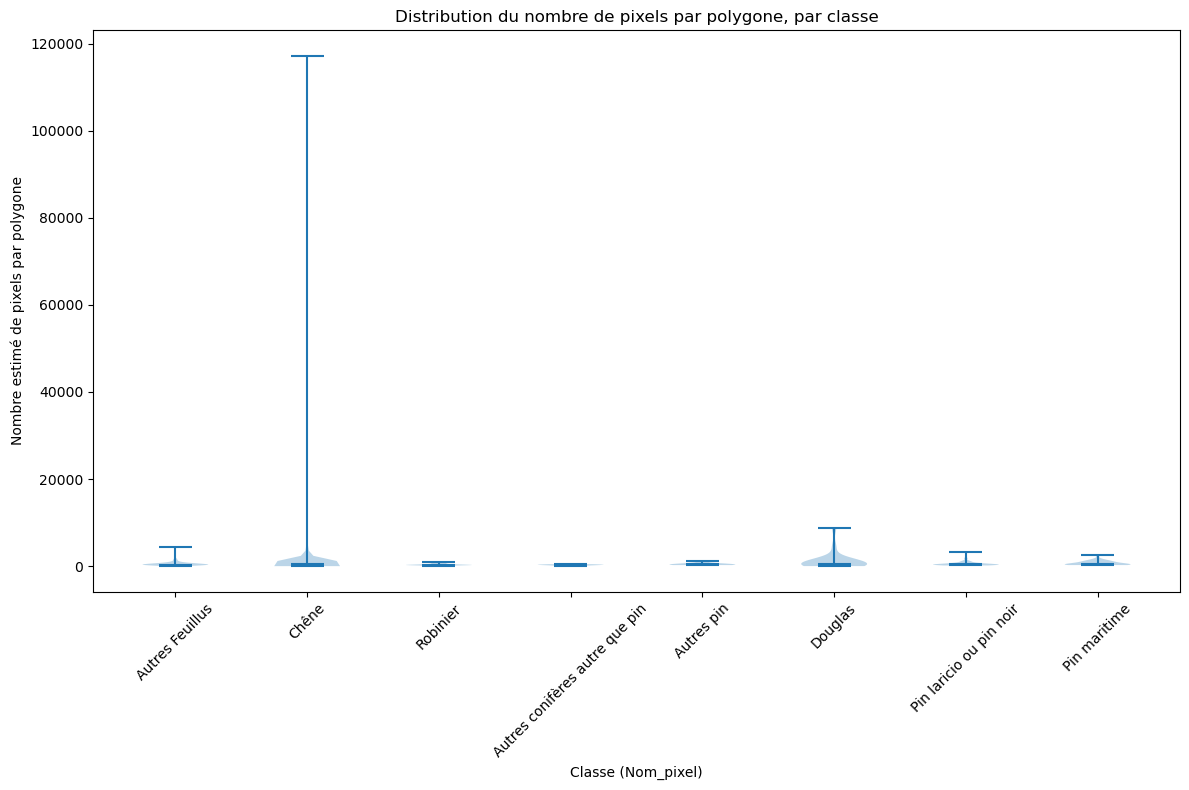

In [61]:
data['polygon_area'] = data.geometry.area  # Aire de chaque polygone
data['estimated_pixels'] = data['polygon_area'] / (pixel_size * pixel_size)  # Estimation du nombre de pixels

# Diagramme "violin plot" de la distribution du nombre de pixels par polygone
plt.figure(figsize=(12, 8))
classes = data['Code_pixel'].unique()
data_to_plot = []

# Organiser les données par classe
for cls in sorted(classes):
    subset = data[data['Code_pixel'] == cls]
    data_to_plot.append(subset['estimated_pixels'].values)

# Tracer le "violin plot"
plt.violinplot(data_to_plot, showmeans=False, showmedians=True)
plt.title("Distribution du nombre de pixels par polygone, par classe")
plt.xlabel("Classe (Nom_pixel)")  # Afficher le nom de la classe
plt.ylabel("Nombre estimé de pixels par polygone")
plt.xticks(np.arange(1, len(classes) + 1), [class_names[cls] for cls in sorted(classes)], rotation=45)
plt.tight_layout()
plt.savefig("../results/figure/violin_plot_nb_pix_by_poly_by_class.png")
plt.show()  # Afficher le graphique
plt.close()